In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [51]:
base_dir = "/eos/home-d/dvalsecc/www/VBSPlots/DNN_archive/"

plot_configs  = ["Full2016v6s5_v2","Full2017v6s5_v2","Full2018v6s5_v2"]
#cut     = "boos_sig_mjjincl"
cut     = "res_sig"
version = "v11"

output_dir = os.path.join(base_dir, "FullRun2", cut, "samples/" + version)

samples_dirs = [os.path.join(base_dir, p, cut, "samples/" + version) for p in plot_configs]

In [27]:
samples_dirs

['/eos/home-d/dvalsecc/www/VBSPlots/DNN_archive/Full2016v6s5_v2/res_sig/samples/v11',
 '/eos/home-d/dvalsecc/www/VBSPlots/DNN_archive/Full2017v6s5_v2/res_sig/samples/v11',
 '/eos/home-d/dvalsecc/www/VBSPlots/DNN_archive/Full2018v6s5_v2/res_sig/samples/v11']

In [28]:
classes = { "VBS": 0, "Wjets":1, "top": 2, "DY": 3, "VV":4, "VBF-V":5, "VVV":6}
signal = "VBS"
sample_names = ["Wjets", "VBS", "DY", "top", "VV", "VBF-V", "VVV"]

samples = {}

for samples_dir in samples_dirs:
    for file in os.listdir(samples_dir):
        if os.path.isdir(os.path.join(samples_dir, file)): continue
        print(file)  
        if file =="index.php": continue
        sname = file.split("_part")[0]
        s = pickle.load(open(os.path.join(samples_dir, file), "rb"))
        s.rename(columns=lambda c: c.split(cut+"_")[1] if cut in c else c, inplace=True)
        s["sample_name"]= sname
        s["class"] = classes[sname]
        if sname == signal:
            s["signal"] = 1
        else: 
            s["signal"] = 0
        if sname in samples:
            samples[sname] = pd.concat([samples[sname], s], ignore_index=True)
        else:
            samples[sname] = s

DY_part1.pkl
VVV_part1.pkl
Wjets_part1.pkl
Wjets_part2.pkl
index.php
top_part1.pkl
DY_part1.pkl
DY_part2.pkl
DY_part3.pkl
VBF-V_part1.pkl
VBS_part1.pkl
VVV_part1.pkl
VV_part1.pkl
Wjets_part1.pkl
Wjets_part2.pkl
Wjets_part3.pkl
index.php
top_part1.pkl
DY_part1.pkl
DY_part2.pkl
DY_part3.pkl
VBF-V_part1.pkl
VBS_part1.pkl
VVV_part1.pkl
VV_part1.pkl
Wjets_part1.pkl
Wjets_part2.pkl
index.php
top_part1.pkl


In [29]:
for s, df in samples.items():
    print(f"Sample name {s:10}, nsamples: {len(df):10},   XS total: {(df.weight_).sum()*41.5 :15}")

Sample name DY        , nsamples:     165390,   XS total: 23568.291226005622
Sample name VVV       , nsamples:       2619,   XS total: 58.7295356013042
Sample name Wjets     , nsamples:     526065,   XS total: 108239.66473902499
Sample name top       , nsamples:     177307,   XS total: 17902.215334335084
Sample name VBF-V     , nsamples:       5991,   XS total: 1996.5070888315786
Sample name VBS       , nsamples:     151771,   XS total: 740.2109243533764
Sample name VV        , nsamples:     290439,   XS total: 4657.254668511865


In [28]:
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.preprocessing import LabelEncoder 

## Balancing

In [30]:
background = pd.concat([
                samples["top"],
                samples["DY"],
                samples["Wjets"],
                samples["VV"],
                samples["VBF-V"], 
                ], ignore_index=True)

In [31]:
signal = samples["VBS"]

In [32]:
ratio_neve_bkgsignal= len(background) / len(signal)
print(ratio_neve_bkgsignal)

7.6773033056381


In [33]:
tot_ev_weighted_sig = (signal.weight_ / signal.weight_.mean()).sum()
print("TOT signal weighted events", tot_ev_weighted_sig)

TOT signal weighted events 151771.0


In [34]:
rescale_factor_bkg = (tot_ev_weighted_sig *ratio_neve_bkgsignal )/ background.weight_.sum()
print(rescale_factor_bkg)

309.2494992592871


In [35]:
signal["weight_norm"] = signal.weight_ / signal.weight_.mean()
background["weight_norm"] = background.weight_ * rescale_factor_bkg

## Save signal and bkg samples

In [53]:
import os

os.makedirs(os.path.join(output_dir, "for_training"), exist_ok=True)
pickle.dump(background, open(os.path.join(output_dir, "for_training/background_balanced.pkl"), "wb"))
pickle.dump(signal, open(os.path.join(output_dir, "for_training/signal_balanced.pkl"), "wb"))

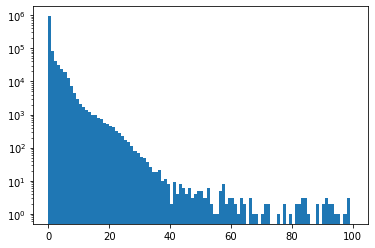

In [37]:
plt.hist(background["weight_norm"], bins=100, range=(0, 100))
plt.yscale("log")

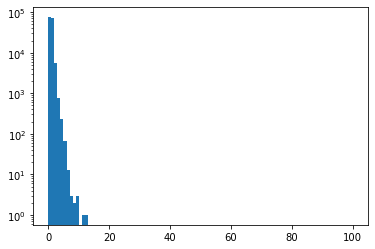

In [38]:
plt.hist(signal["weight_norm"], bins=100, range=(0, 100))
plt.yscale("log")

The total number of events will be manually balanced

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

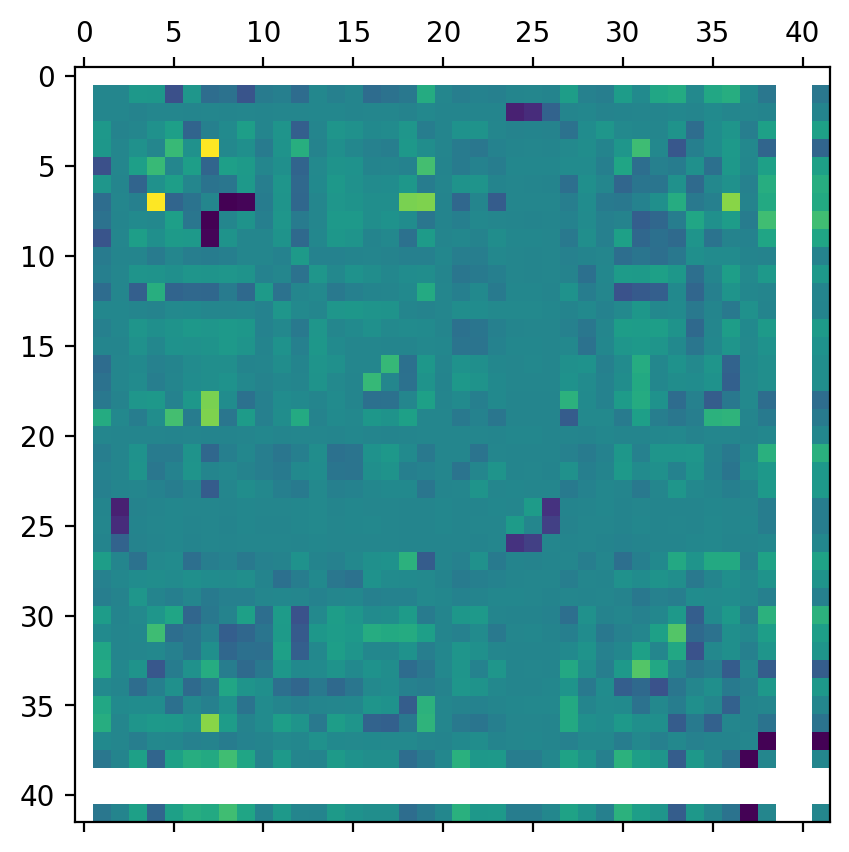

In [50]:
fig, ax = plt.subplots(figsize=(5,5), dpi=200)
ax.matshow(signal.corr()- background.corr())
plt.colorbar()